In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **L'implementation de architecture U-net**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = tf.keras.activations.relu(c1, alpha=0.0, max_value=None, threshold=0)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = tf.keras.activations.relu(c2, alpha=0.0, max_value=None, threshold=0)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = tf.keras.activations.relu(c3, alpha=0.0, max_value=None, threshold=0)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = tf.keras.activations.relu(c4, alpha=0.0, max_value=None, threshold=0)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

## **L'importation des images et des bibliothèques utilise**

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
ls '/content/drive/MyDrive/output_folder/BloodImageSetS6NucSeg/'

image/  index1.txt  index.txt  Nucleus/


In [ ]:
image_directory = '/content/drive/MyDrive/output_folder/BloodImageSetS6NucSeg/image/'
mask_directory = '/content/drive/MyDrive/output_folder/BloodImageSetS6NucSeg/Nucleus/'

## **Image preprocessing**

In [ ]:
SIZE = 128
image_dataset = []  
mask_dataset = []  

In [ ]:
#arranger les photos avec un ordre alphabétique pour éviter le décalage 
images = os.listdir(image_directory)
images = sorted(images)


In [ ]:
#Image preprocessing
for i, image_name in enumerate(images):  
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory+image_name,0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


masks = os.listdir(mask_directory)
masks = sorted(masks)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(mask_directory+image_name, cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))
print("DONE!!")


DONE!!


In [ ]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)


In [ ]:
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.1, random_state = 0)

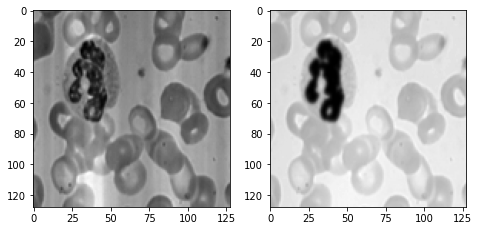

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE)), cmap='gray')
plt.subplot(132)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap='gray')


In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [ ]:
def get_model():
    return unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = get_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fcit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)
model.save('/content/drive/MyDrive/Models/UnetModel_test6.hdf5')

Epoch 1/100
42/42 [==============================] - 68s 1s/step - loss: 0.6325 - accuracy: 4.2892e-04 - val_loss: 0.6091 - val_accuracy: 0.0000e+00
Epoch 2/100
42/42 [==============================] - 48s 1s/step - loss: 0.6074 - accuracy: 2.7777e-04 - val_loss: 0.6552 - val_accuracy: 0.0201
Epoch 3/100
42/42 [==============================] - 48s 1s/step - loss: 0.5943 - accuracy: 0.0128 - val_loss: 0.6024 - val_accuracy: 0.0199
Epoch 4/100
42/42 [==============================] - 48s 1s/step - loss: 0.5848 - accuracy: 0.0148 - val_loss: 0.6034 - val_accuracy: 0.0200
Epoch 5/100
42/42 [==============================] - 48s 1s/step - loss: 0.5806 - accuracy: 0.0157 - val_loss: 0.5993 - val_accuracy: 0.0199
Epoch 6/100
42/42 [==============================] - 48s 1s/step - loss: 0.5804 - accuracy: 0.0155 - val_loss: 0.6001 - val_accuracy: 0.0200
Epoch 7/100
42/42 [==============================] - 48s 1s/step - loss: 0.5791 - accuracy: 0.0158 - val_loss: 0.5869 - val_accuracy: 0.0198
E

KeyboardInterrupt: ignored

In [ ]:
model = get_model()
model.load_weights('/content/drive/MyDrive/Models/UnetModel_test6.hdf5')

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 128, 128, 16) 160         input_6[0][0]                    
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 128, 128, 16) 0           conv2d_75[0][0]                  
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 128, 128, 16) 2320        dropout_35[0][0]                 
____________________________________________________________________________________________

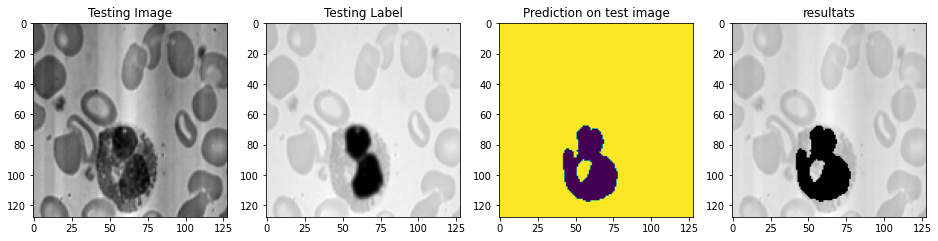

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(prediction)
plt.subplot(244)
plt.title('resultats')
plt.imshow((test_img[:,:,0]*prediction), cmap='gray')


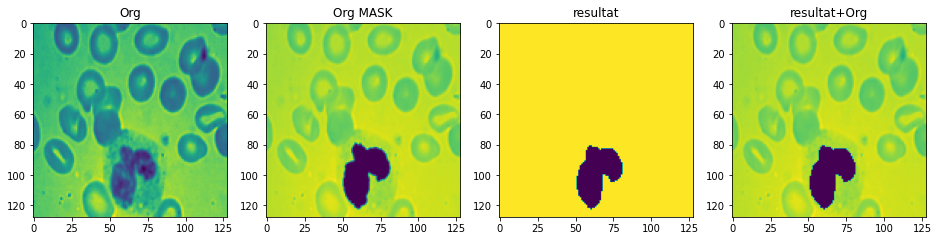

In [ ]:

imageCC = cv2.imread('/content/drive/MyDrive/output_folder/BloodImageSetS6NucSeg/Nucleus/BloodImage_00167.jpg',0)
imageCC = Image.fromarray(imageCC)
imageCC = imageCC.resize((SIZE, SIZE))
image = cv2.imread('/content/drive/MyDrive/output_folder/BloodImageSetS6NucSeg/image/BloodImage_00167.jpg',0)
image = Image.fromarray(image)
image = image.resize((SIZE, SIZE))
test_img_other_norm = np.expand_dims(normalize(np.array(image), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.5).astype(np.uint8)


plt.figure(figsize=(16, 8))
plt.subplot(141)
plt.title('Org')
plt.imshow(image,)
plt.subplot(142)
plt.title('Org MASK')
plt.imshow(imageCC,)
plt.subplot(143)
plt.title('resultat')
plt.imshow(prediction_other)
plt.subplot(144)
plt.title('resultat+Org')
plt.imshow(image*prediction_other)